<a href="https://colab.research.google.com/github/Nitpreetik13/Air-Pollution-Prediction-using-LSTM/blob/main/airpollutionprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/air-quality-india.csv')

In [ ]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [ ]:
import datetime
import math


In [ ]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [ ]:
df['Date']=df["Timestamp"].dt.date

In [ ]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5,Date
0,2017-11-07 12:00:00,2017,11,7,12,64.51,2017-11-07
1,2017-11-07 13:00:00,2017,11,7,13,69.95,2017-11-07
2,2017-11-07 14:00:00,2017,11,7,14,92.79,2017-11-07
3,2017-11-07 15:00:00,2017,11,7,15,109.66,2017-11-07
4,2017-11-07 16:00:00,2017,11,7,16,116.50,2017-11-07


AVERAGE OF DAYS PM 2.5

In [ ]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


SPILLITED DATA INTO RATIO OF 80 TO 20 FOR TRAINING AND TESTING

In [ ]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1293

USED MINMAXSCALER FOR REDUCING COMPLEXITY AND INCRESING EFFCIENCY OF MODEL TAKING RANGE BETWEEN 0 TO 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

CREATING SEQUENCE FOR TIME SERIES PREDICTION
USED 60 AS (RANDOM DATA POINTS)

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

CONVERTING INTO NP ARRAYS AND RESHAPING THE ARRAYS TO EXPECTDED 3D MODEL

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1233, 60, 1)

MODELING

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

1233/1233 [==============================] - 42s 31ms/step - loss: 0.0068


PREDICTION

In [ ]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

11/11 [==============================] - 1s 14ms/step


In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.7487096025440909

In [ ]:
mse = np.mean(predictions - y_test)**2
mse

0.5605660689417306

In [ ]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

<ipython-input-70-ac3bd275f73e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


,PM2.5,Predictions
Date,,
2021-06-28,28.667917,27.425863
2021-06-29,30.903750,27.454975
2021-06-30,29.017917,28.247686
2021-07-01,27.166667,28.642345
2021-07-02,27.132917,28.391088
...,...,...
2022-05-31,41.465417,37.282372
2022-06-01,41.645833,38.425579
2022-06-02,42.255417,39.701210


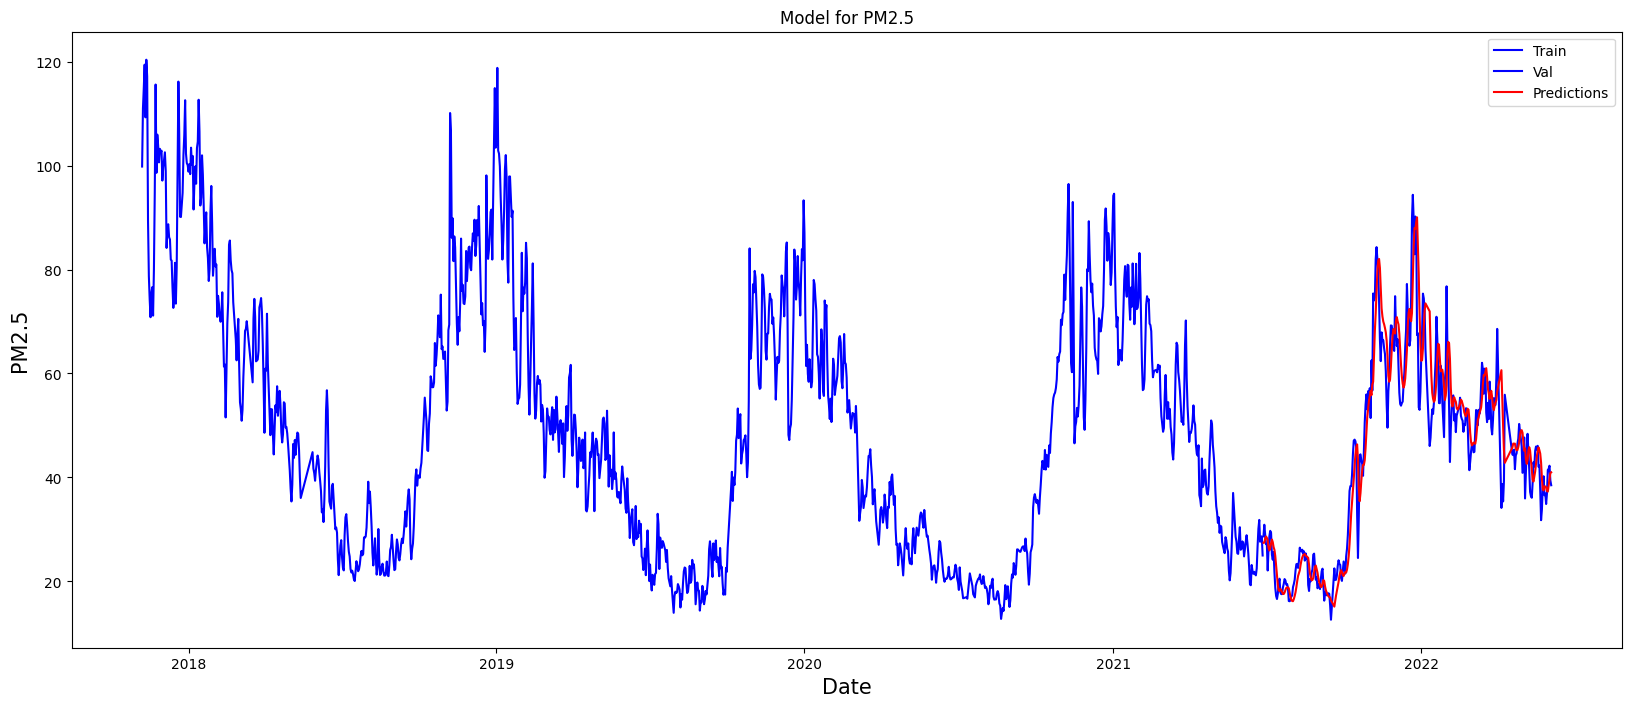

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize=15)
plt.ylabel("PM2.5", fontsize=15)


plt.plot(train[df_date.columns], color='blue')
plt.plot(valid['PM2.5'], color='blue')
plt.plot(valid["Predictions"], color='red')

plt.legend(["Train", "Val", "Predictions"])
plt.show()

<Axes: xlabel='Year'>

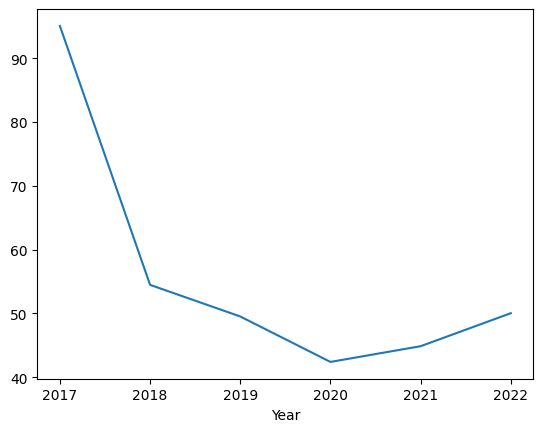

In [ ]:
df.groupby('Year')['PM2.5'].mean().plot()